In [6]:
# Zachary Katz
# zachary_katz@mines.edu
# 04 December 2025

"""
Download two ATL 06 granules using Earthaccess and plot over 
Subglacial Lake Cheongsuk outline from Ju et al., 2025, available at
https://dx.doi.org/doi:10.22663/KOPRI-KPDC-00001177

"""

# Imports
import h5py
import shapefile
import earthaccess
import numpy as np
from pathlib import Path
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyproj import CRS, Transformer

# Requires NASA Earthdata Login, https://urs.earthdata.nasa.gov/
earthaccess.login() # Looks for .netrc, fails back to interactive prompt

# User-defined paths
atl06_path = './_Data/ATL06' # Download path for ATL06 granules
dl_path = './SLD' # Path to David Subglacial Lake Cheongsuk Shapefile

# Make atl06_path if it doesn't exist
Path(atl06_path).mkdir(parents=True, exist_ok=True)

# Conversion function for plotting
def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """
    
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

In [7]:
# Download data progrmaticallly using earthaccess
# Earthaccess automatically checks and skips files already downloaded

granules = ['ATL06_*_00012710_007_01.h5',
'ATL06_*_03752712_007_01.h5']

"""
NOTE:
I got these specific granule name from Earthdata search, by clicking the 'NASA 
Earthdata Search' box on NSIDC (https://nsidc.org/data/atl06/versions/7). This 
NSIDC landing page has other useful information such as links to the product 
description documents.

Alternatively, you can search by spatial, temporal, etc. extent instead of 
finding a specific granule name. An example is in the Earthaccess documentation: 
(https://earthaccess.readthedocs.io/en/latest/tutorials/file-access/). Wildards
* and ? in the granule name are also accepted.
"""

short_name = 'ATL06'
st = '2025-06-01'
ed = '2025-12-31'

for granule in granules:
    results = earthaccess.search_data(short_name = short_name, granule_name=granule) # Searches and returns matching granules
    earthaccess.download(results, atl06_path, provider='POCLOUD') # Downloads the granules (h5 files for ATL06)

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1243.13it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:21<00:00, 21.12s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9000.65it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 999.36it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:25<00:00, 25.97s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6186.29it/s]


In [8]:
# Load downloaded ALT06 data

arr06 = [] # Final array of ICESat-2 ATL06 Dictionaries

files = list(Path(atl06_path).glob('*.h5'))
group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r'] # Each beam of ATL06 is a separate group

for file in files[:]: # Loop over files
    for i, g in enumerate(group): # Loop over beams
        data = {}
        try:
            # Load variables into dictionary list
            with h5py.File(file, 'r') as fi:
                data['lat'] = fi[g+'/land_ice_segments/latitude'][:] #Deg
                data['lon'] = fi[g+'/land_ice_segments/longitude'][:] #Deg
                data['h_li'] = fi[g+'/land_ice_segments/h_li'][:] #Land Ice Height, meters
                data['t_dt'] = fi[g+'/land_ice_segments/delta_time'][:] #GPS seconds since reference epoch
                data['q_flag'] = fi[g+'/land_ice_segments/atl06_quality_summary'][:] #0 likely no problem; 1 problems #See table 4-3 in IceSat2 ATBD
                data['geoid_h'] = fi[g+'/land_ice_segments/dem/geoid_h'][:] #Geoid height, meters

                data['x'], data['y'] = ll2xy(data['lon'],data['lat']) # Convert to Polar Stereographic

                # Mask out bad data
                mask_q = data['q_flag'] == 1
                mask_h_li = data['h_li'] > 3.e+35;
                data['h_li'][mask_q] = np.nan
                data['h_li'][mask_h_li] = np.nan

                data['h_li_corrected'] = data['h_li'] - data['geoid_h'] # Quick geoid correction; should also correct for tides, DAC, etc.

        except Exception as e:
            print(e)
            print('Skiiping group: ', g)
            print('in file: ', file)
            continue
        
        arr06.append(data)


In [9]:
# Load Subglacial Lake Cheongsuk shapefile
pathA = dl_path + '/SLD2-A.shp'
pathB = dl_path + '/SLD2-B.shp'
pathC = dl_path + '/SLD2-C.shp'

xs = []
ys = []
for path in [pathA, pathB, pathC]:
    sf = shapefile.Reader(path)
    shapes = sf.shapes()
    for shp in shapes:
        points = shp.points
        x = [p[0] for p in points]
        y = [p[1] for p in points]
    xs.append(x)
    ys.append(y)


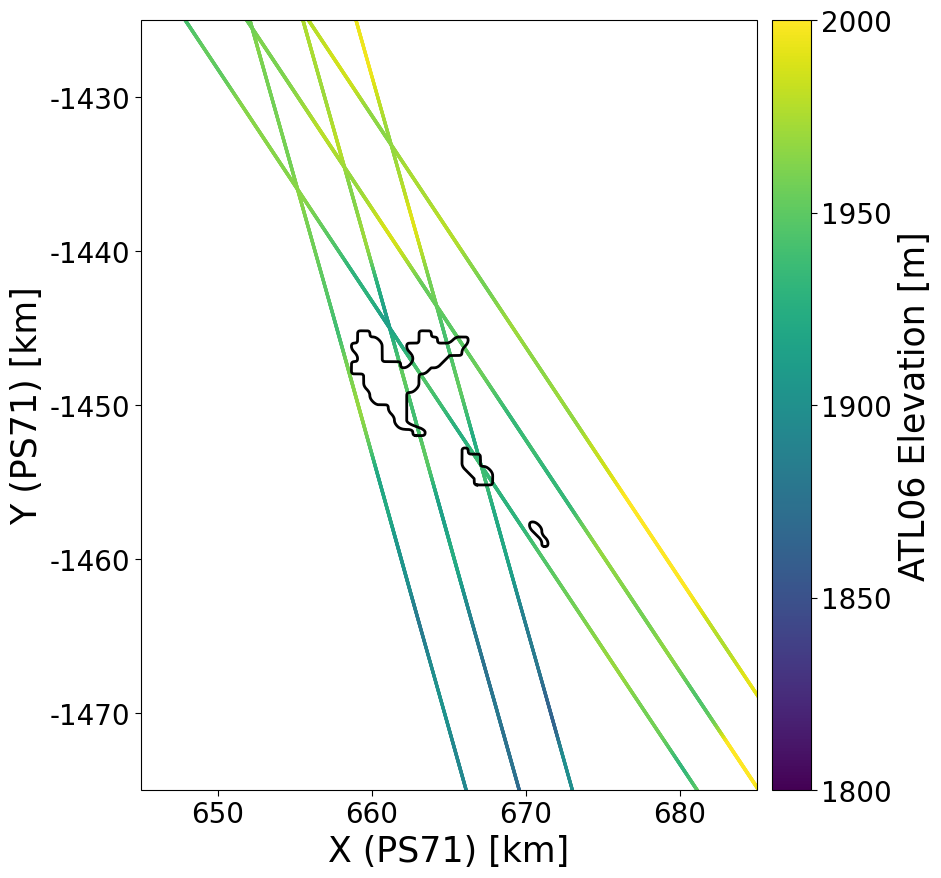

In [10]:
# Plot Tracks and Lake Outline

bbox = [645000,-1475000,685000,-1425000] # Lake Bounding Box
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ps71_projection})

# Lake Outline
for x, y in zip(xs, ys):
    ax.plot(x, y, color='black', linewidth=2)

# ICESat-2 ATL06
vmin = 1800
vmax = 2000
for i, data in enumerate(arr06[:]):
    hgt = ax.scatter(
        data['x'],
        data['y'],
        c=data['h_li_corrected'],
        s=0.2,
        vmin=vmin,
        vmax=vmax,
        transform=ps71_projection)

ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])


# Colorbar and Axes Labels
cbar = plt.colorbar(hgt, ax=ax, orientation='vertical', pad=0.02, fraction=0.05)
cbar.set_label('ATL06 Elevation [m]', fontsize=25)
cbar.ax.tick_params(labelsize=20, size=4)
ticks = np.arange(vmin, vmax+1, 50)
cbar.set_ticks(ticks)

KM_SCALE = 1e3
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xlabel('X (PS71) [km]',size=25)
ax.set_ylabel('Y (PS71) [km]',size=25)
ax.tick_params(labelsize=20, size=4)

# Save Figure
out_path = './_output'
Path(out_path).mkdir(parents=True, exist_ok=True)
fig.savefig(out_path + '/ATL06_David.png', dpi=300, bbox_inches='tight')